# Assignment 5

**Assignment 5: Neuroevolution**

**Goal**: ​Get familiar with neural architecture search by applying an evolutionary algorithm to select the best architecture of a neural network.

In this assignment, we are going to use an evolutionary algorithm for selecting the best architecture of a neural network. As such, this assignment can be seen as a combination of assignment 3 and assignment 4. Similar to assignment 4, the neural network is trained on images (the code is implemented in PyTorch).

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pickle
import copy
import random
from scipy.integrate import solve_ivp
from math import floor

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""
    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

## 2 Neural Networks module

### 2.1.1 Neural Network helper functions

In [3]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).

# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size # a list
  
    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
  
    def forward(self, x):
        return x.view(x.shape[0], -1)

### 2.1.2 Neural Network Classifier

In [4]:
# Implement a neural network (NN) classifier. 
class ClassifierNeuralNet(nn.Module):
    def __init__(self, confg_list):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        # The loss function (the negative log-likelihood)
        self.LogSoftMax = nn.LogSoftmax(dim=1)
        self.nll = nn.NLLLoss() #it requires log-softmax as input!!
        # We create a configuration list to have easier to all configurations-
        # for generating populations in the evolutionary algorithm later
        self.confg_list = confg_list
        
        # We provide a sequential module with layers and activations
        self.num_filters = confg_list[0]
        self.size_kernel = confg_list[1][0]
        self.size_padding = confg_list[1][1]
        self.pool_size = confg_list[2]
        self.pool_type = confg_list[3]
        self.activation_1 = confg_list[4]
        self.activation_2 = confg_list[5]
        self.output_neurons = confg_list[6]
        self.height_1 = ((8 - self.size_kernel + (2*self.size_padding) )//1) + 1
        self.height_2 = ((self.height_1 - self.pool_size + (2*0) )//1) + 1
        self.lin_input = self.num_filters * self.height_2 * self.height_2
        
        if self.pool_type == 'avg':
            self.pool = nn.AvgPool2d
        else:
            self.pool = nn.MaxPool2d
        
        self.classcnn = nn.Sequential(
            Reshape(size=(1,8,8)),
            nn.Conv2d(in_channels=1, out_channels=self.num_filters,
                      kernel_size=self.size_kernel, stride=1, padding=self.size_padding),
            self.activation_1(),
            self.pool(kernel_size=self.pool_size, stride=1),
            Flatten(),
            nn.Linear(in_features=self.lin_input, out_features=self.output_neurons),
            self.activation_2(),
            nn.Linear(in_features=self.output_neurons, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        outputs = self.classcnn(x)
        max_elements, max_indices = torch.max(outputs, 1)
        y_pred = max_indices.to(torch.long)
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        loss = self.nll(self.classcnn(x),y.long())
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

### 2.2 Evaluation function + Helper for plotting the results

In [5]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, model_best, epoch):
    model_best.eval()# set the model to the evaluation mode
    loss_test = 0.
    loss_error = 0.
    N = 0.
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.*(y_pred == test_targets.long())
        loss_error = loss_error + (1. - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N
    return loss_test, loss_error

# An auxiliary function for plotting the performance curves
def plot_curve(name, signal, file_name='curve.pdf', xlabel='epochs', ylabel='nll', color='b-', test_eval=None):
    # plot the curve
    plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel +' test')
        plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches='tight')
    plt.show()

### 2.3 Training procedure

In [6]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    error_val = []
    best_nll = 1000.
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train() # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()
        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(test_loader=val_loader, model_best=model, epoch=num_epochs)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no 
        # progress is observed.
        if e == 0:
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break
    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)
    return nll_val, error_val

### 3 Evolutionary Algorithm module

In [7]:
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, pop_size, evaluation_function):
        self.pop_size = pop_size
        self.eval_fn = evaluation_function
        # We will use nr_of_parents to determine the number of parents that will be selected for mating
        self.nr_of_parents = 6
        self.epoch_nr = 1
        self.learning_rate = 1e-3
        self.weight_decay = 1e-5
        self.max_patience = 1

    def evaluate(self, data, model, w_list):
        loss_error = self.eval_fn(test_loader=data, model_best=model, epoch=self.epoch_nr)[1]
        model_total_params = sum(p.numel() for p in model.parameters())
        p = 0.01 * (model_total_params/max(w_list))
        return loss_error + p
        
    def parent_selection(self, x_old, f_old, w_old):
        # The self.nr_of_parents is the number of parents that are selected in each mating
        x_parents = []
        f_parents = []
        w_parents = []
        for i in range(self.nr_of_parents):
            # Here, we will choose the parents with the best fitness among the population
            # Note: Normally the Evolutionary Algorithm works towards -
            # maximising the measure objective (fitness function).
            # This means that the higher the f_old value is the fitter the parents are.
            # However, since our optimization task is to minimize the value of f_old,-
            # we use np.min() to pick the fittest parents.
            # min_ind is the index with the parent that has the minimum f_old value.
            np.asarray(f_old)
            min_ind = np.where(f_old == np.min(f_old))
            min_ind = min_ind[0][0]
            # Here we choose the parent with the minimum fitness value from-
            # our population and add them to our selected parents
            x_parents.append(x_old[min_ind])
            # Here we add the number of weights of this parent to our weights list (for evaluation purposes)
            w_parents.append(sum(p.numel() for p in x_old[min_ind].parameters() if p.requires_grad==True))
            # We then return the fittness of all the parent by using our evaluation function-
            # and we save them in the variable f_parents
            f_parents.append(f_old[min_ind])
            # Here we set the minumum value of f_old that we just used for selection-
            # to +infity to avoid duplication when we want to select the other parents.
            f_old[min_ind] = float('inf')
        return x_parents, f_parents, w_parents

    def recombination(self, x_parents):
        # We set the size of the children population that we want to create in "children_size"
        # The algorithm for this is the size of the original population minus the number of parents-
        # that we have selected. This formula can be modified to ones desire dependng on the task at hand
        children_size = self.pop_size-self.nr_of_parents
        # We create an empty array to add the childrens after mating 
        rand_int = random.randint(0,6)
        x_children = []
        for j in range(children_size):
            child_conf = []
            # Index of the first parent for mating
            P_a = random.randint(0,len(x_parents)-1)
            # Index of the second parent for mating
            P_b = random.randint(0,len(x_parents)-1)
            P_a_conf = x_parents[P_a].confg_list
            P_b_conf = x_parents[P_b].confg_list
            child_conf [:rand_int] = P_a_conf[:rand_int]
            child_conf [rand_int:] = P_b_conf[rand_int:]
            # The new child will have its values from the parents by averaging the values of two parents together
            new_child = ClassifierNeuralNet(child_conf)
            x_children.append(new_child)
        return x_children
    
    def mutation(self, x_children, w_old, training_fn, training_loader, val_loader):
        f_children = []
        w_children = []
        cnn_filters = [8,16,32]
        cnn_kernel_paddings = [[2,1],[5,2]]
        cnn_pooling_sizes = [2,1]
        cnn_pooling_types = ['max', 'avg']
        cnn_activations = [nn.Tanh, nn.ReLU,nn.Sigmoid,nn.ELU,nn.Softplus]
        cnn_linear_neurons = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        all_choices = [cnn_filters, cnn_kernel_paddings, cnn_pooling_sizes,
                      cnn_pooling_types, cnn_activations, cnn_activations, cnn_linear_neurons]
        # we randomly modify a single value in each reproduced child.
        for j in range(len(x_children)):
            random_index = random.randint(0,6)
            # We generate a random value for replacement
            random_modification = random.choice(all_choices[random_index])
            # We replace the value of the child with our random value
            x_children[j].confg_list[random_index] = random_modification   
            optimizer = torch.optim.Adamax([p for p in x_children[j].parameters() if p.requires_grad == True], 
                                           lr=self.learning_rate, weight_decay=self.weight_decay) 
            training_fn(max_patience=self.max_patience, num_epochs=self.epoch_nr, model=x_children[j],
                        optimizer=optimizer, training_loader=training_loader, val_loader=val_loader)
            f_new_child = self.evaluate(data=val_loader, model=x_children[j], w_list=w_old)
            w_children.append(sum(p.numel() for p in x_children[j].parameters() if p.requires_grad==True))
            f_children.append(f_new_child)

        return x_children, f_children, w_children

    def survivor_selection(self, x_old, x_parents, x_children, f_old, f_parents, f_children, w_old, w_parents, w_children):
        # We update our original population.
        # Note: There are number of approaches that can be taken here, but we choose "elitism".
        # The choise of "Elitism" is explained in more detail in the report.
        # We will replace the population entirely by the parents and children
        x = x_parents + x_children
        f = f_parents + f_children
        w = w_parents + w_children
        return x, f, w
  
    def step(self, x_old, f_old, w_old, training_fn, training_loader, val_loader):
        x_parents, f_parents, w_parents = self.parent_selection(x_old, f_old, w_old)
        x_children = self.recombination(x_parents)
        x_children, f_children, w_children = self.mutation(x_children, w_old, training_fn, training_loader, val_loader)
        x, f, w = self.survivor_selection(x_old, x_parents, x_children, f_old, f_parents, f_children, w_old, w_parents, w_children)
        return x, f, w

#### Initialize dataloaders

In [8]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

#### Initialize hyperparameters

In [9]:
# PLEASE DO NOT REMOVE!
D = 64   # input dimension
# -> model hyperparams
K = 10 # the number of labels
# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 1 # max. number of epochs
max_patience = 1 # an early stopping is used, if training doesn't improve for longer than 5 epochs, it is stopped
num_generations = 100 # number of generation to create (the iterations of the EA algorithm)
pop_size = 100 # population size in each iteration of the EA algorithm
population = [] # initiating the population list
fitness = [] # initiating the population's fitness list
weights = [] # initiating the population's number of weights list
configurations_init = [] # initiating an empty configuration list to assist in generating different individuals
cnn_filters = [8, 16, 32] # initiating the list of choices for the filters of the CNN
cnn_kernel_paddings = [[2,1],[5,2]] # initiating the list of choices for the Kernel-Padding of the CNN
cnn_pooling_sizes = [2,1] # initiating the list of choices for the Pooling sizes of the CNN
cnn_pooling_types = ['max', 'avg'] # initiating the list of choices for the Pooling types of the CNN
cnn_activations = [nn.Tanh, nn.ReLU,nn.Sigmoid,nn.ELU,nn.Softplus] # initiating the list of choices for the Activation methods for layers
cnn_linear_neurons = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # initiating the list of choices for the number of neurons of the linear layer

#### Initialize population

In [10]:
# Generating the population and calculating their fitnees
for i in range(pop_size):
    # Here, we pick a random value for each choice of the CNN desing
    # This line chooses a rendom value from the filter list of [8, 16, 32]
    filter_choice = random.choice(cnn_filters)
    # This line chooses a rendom value from the Kernel-Padding list of [[2,1],[5,2]]
    kernel_padding_choice = random.choice(cnn_kernel_paddings)
    # This line chooses a rendom value from the Pooling sizes list of [2,1]
    pooling_size_choice = random.choice(cnn_pooling_sizes)
    # This line chooses a rendom value from the Pooling types list of ['max', 'avg']
    pooling_type_choice = random.choice(cnn_pooling_types)
    # This line chooses a rendom value from the Activation methods list of [nn.Tanh, nn.ReLU,nn.Sigmoid,nn.ELU,nn.Softplus]-
    # for the first activation
    activation_choice_1 = random.choice(cnn_activations)
    # This line chooses a rendom value from the Activation methods list of [nn.Tanh, nn.ReLU,nn.Sigmoid,nn.ELU,nn.Softplus]-
    # for the second activation
    activation_choice_2 = random.choice(cnn_activations)
    # This line chooses a rendom value from the number of neurons list of [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    # Note: This value is used for both the output of the first and the input of the second linear layer.
    linear_neurons_choice = random.choice(cnn_linear_neurons)
    # We creates a configuration list with all the random choices
    rand_confg_list = [filter_choice, kernel_padding_choice, pooling_size_choice, pooling_type_choice, activation_choice_1,
                      activation_choice_2, linear_neurons_choice]    
    # We then creates a model (individual) with these configurations
    CNN_Model = ClassifierNeuralNet(rand_confg_list)
    # We define our optimizer for training (choices are explain in the report)
    optimizer = torch.optim.Adamax([p for p in CNN_Model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 
    # We train each individual for 10 epochs
    training(max_patience=max_patience, num_epochs=num_epochs, model=CNN_Model,
            optimizer=optimizer, training_loader=training_loader, val_loader=val_loader)
    # We measure evaluate of each individual and add it to the initial fitnees list
    # Note: The penalty for the weights is added in the next cell.
    fitness.append(evaluation(test_loader=val_loader, model_best=CNN_Model, epoch=num_epochs)[1])
    # We calulate the number of weights of each individual and add it to the initial weights list
    weights.append(sum(p.numel() for p in CNN_Model.parameters() if p.requires_grad))
    # We add our individual to our initial population list
    population.append(CNN_Model) 
    # Note: This loop runs for the number of our pop-size=100 to create the entire initial population

In [11]:
# We calculate the penalty for the number of weights of each individual
penalty = [(0.01 * (i/max(weights))) for i in weights]
# We add the penalties and adjust the fitnees list accordingly
fitness = [j + k for j, k in zip(penalty, fitness)]

#### running the Evolutionary Algorithm process

In [12]:
# We difine our object for the EA algorithm in order to call it later
ea = EA(pop_size,evaluation)
# We difine the f_best list to keep track of the best fitnees of the generations for the convergence plot
f_best = [min(fitness)]
# We difine the best_ind variable to keep track of the best individual (CNN) of the generations
best_ind = []
# We run the EA algorithm for the num_generations=100
for i in range(num_generations):
    # Since this number is very large, we only print each 10% of the genration (40,80,120,etc.)
    if i % int(num_generations * 0.1) == 0:
        # Print the best fitness of the corresponding generation
        print('Generation: {}, best fitness: {}'.format(i, min(fitness)))
        # Create the next generation based on the new population
        population, fitness, weights = ea.step(x_old=population, f_old=fitness, w_old=weights, 
                                               training_fn=training, training_loader=training_loader,val_loader=val_loader)
    # If there is a lower fitnees among the new population, add it to the f_best and find the corresponding model
    if  min(fitness) < f_best[-1]:
        np.asarray(fitness)
        # We find the index of the best fitness
        min_ind = np.where(fitness == np.min(fitness))
        min_ind = min_ind[0][0]
        # We identify the individual in the population with the same index as the best individual-
        # and add it to our list of best individuals from each generation
        best_ind.append(population[min_ind])
        # We add the new best fitnees to the f_best list
        f_best.append(min(fitness))
    # If there is no lower fitnees than the previous one, add the previous as the remainign best fitness for now
    else:
        f_best.append(f_best[-1])

print('FINISHED!')

Generation: 0, best fitness: 0.07549528059388431
Generation: 10, best fitness: 0.04508690973150452
Generation: 20, best fitness: 0.04508690973150452
Generation: 30, best fitness: 0.04508690973150452
Generation: 40, best fitness: 0.0421977660457757
Generation: 50, best fitness: 0.0421977660457757
Generation: 60, best fitness: 0.0421977660457757
Generation: 70, best fitness: 0.0421977660457757
Generation: 80, best fitness: 0.0421977660457757
Generation: 90, best fitness: 0.0421977660457757
FINISHED!


In [13]:
print("best individual of the last generation (overall) is: {}".format(best_ind[-1]))

best individual of the last generation (overall) is: ClassifierNeuralNet(
  (LogSoftMax): LogSoftmax(dim=1)
  (nll): NLLLoss()
  (classcnn): Sequential(
    (0): Reshape()
    (1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten()
    (5): Linear(in_features=2048, out_features=70, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=70, out_features=10, bias=True)
    (8): LogSoftmax(dim=1)
  )
)


### 4 Experiments

### 4.1 Assignment 4 Plots (For Better Comparison)

In [17]:
#=========
# GRADING:
# 0 
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
#=========
# Implement a neural network (NN) classifier. 
class ClassifierNeuralNetAssignment4(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNetAssignment4, self).__init__()
        # We provide a sequential module with layers and activations
        # The output of this module is a LogSoftmax.
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss() #it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # We first feed the input to the neural network model.
        # The output of this model is a Logsoftmax which declares the log-probabilities-
        # Of each k (10) classes.
        outputs = self.classnet(x)
        # We then pick the highest log-probability value-
        # and find which index (classes of 0-9) it belongs to
        max_elements, max_indices = torch.max(outputs, 1)
        # We translate the found class (index) to a torch.long value-
        # and we output this as y_pred 
        y_pred = max_indices.to(torch.long)
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        # The nn.NLLLoss takes a LogSoftmax probabilty and a target value (long value)-
        # as input. It then calculates the loss of the neural network model.
        loss = self.nll(self.classnet(x),y.long())
        # We also need to define how the totall loss is calculated.
        # We have two options of "averageing" and "summing" over the losses for our formula.
        # We assign the reduction accourding to the input of our-
        # forward function (which is set to "avg" now)
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()


-> START classifier_mlp
-> FINAL PERFORMANCE: nll=0.005835608431290194, ce=0.09619686800894854


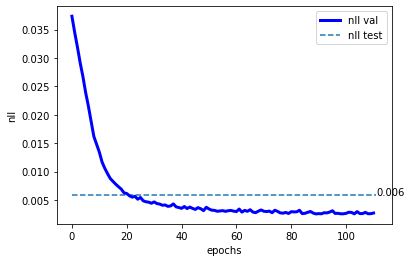

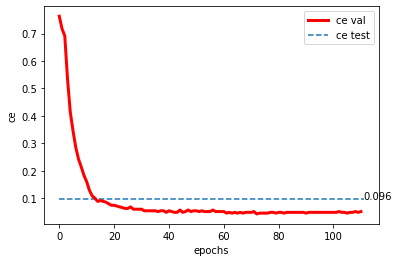


-> START classifier_cnn
-> FINAL PERFORMANCE: nll=0.003172011700119215, ce=0.053691275167785234


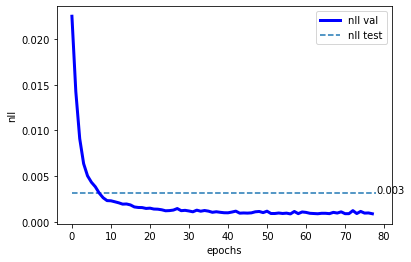

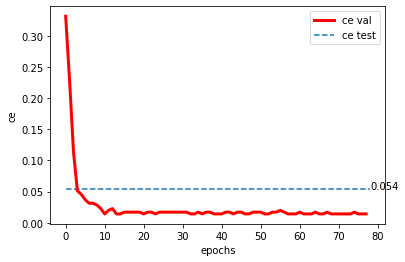

In [22]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ['classifier_mlp', 'classifier_cnn']
results_dir = "results_dir"
# loop over models
for name in names:
    print('\n-> START {}'.format(name))
    # Create a folder if necessary
    result_dir = os.path.join(results_dir, name + '/')
    if not(os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name == 'classifier_mlp':
        classnet = nn.Sequential(
            # We first reshape the input to (1,8,8) to assertain the correct shape of our inputs
            Reshape(size=(1,8,8)),
            # Since we are feeding the inputs to a linear neural network-
            # We need to flatten the images to recieve a 1-dimentional tensor
            Flatten(), #input=1*8*8, output=1*64
            # We start with a layer of 64 (input dimention) neurons because-
            # input features of the first linear layer must macth the number-
            # of pixels of the images. We create 3 sequential linear layers.
            # This number is a modeling choice. The very last linear layer has to output features-
            # equal to the number of classes (here k=10) that we have as labels.
            # Finally, the last layer should be a LogSoftmax() activation layer so-
            # that we can obtain the class log-probabilities as output. We use ReLU activation after-
            # each Linear layer as activation. This is chosen to reduce the effect of negative value (turn them into zeros).
            # Note: Although the number of layers are up to individul's choice,
            # the value of input features of each linear layer must match the output-
            # of the layer before it (to prevent getting errors of mis-matched matrix multiplications.)
            nn.Linear(in_features=64 , out_features=64//2), nn.ReLU(), #input=1*64, output=1*32
            nn.Linear(in_features=64//2 , out_features=64//4), nn.ReLU(), #input=1*32, output=1*16
            nn.Linear(in_features=64//4 , out_features=K), nn.LogSoftmax(dim=1) #input=1*16, output=1*10
        )

    # CNN
    elif name == 'classifier_cnn':
        classnet = nn.Sequential(
            # We first reshape the input to (1,8,8) to assertain the correct shape of our inputs.
            Reshape(size=(1,8,8)),
            # Since we are feeding the inputs to a convolutional neural network-
            # We do not need to flatten the images, and we immidiatly start-
            # with the "Conv2d" layer. Since the input has "1" channel (the image is black and white)-
            # we have "1" as input and "num_kernels" as output channels of the conv2d layer. we chose a kernel-
            # size of 2*2 for this architecture. It is important to note that since the input-
            # is a 8*8 = 16 pixels image, the kernel size must be chosen in a way that does not-
            # exceed or fit the whole image in one go (2*2=4 or 3*3=9 pixels kernel both seem appropriate choices).
            # In addition, we add a padding of 1 (zero rows and columns around the image)-
            # in order to scan the borders more efficiently. We use ReLU activation after the-
            # conv2d layer as activation. This is chosen to reduce the effect of negative value (turn them into zeros).
            # The ouput of the conv2d layer is calculated by the fomula ((W−F+2*P)/S)+1 * ((W−F+2*P)/S)+1 with-
            # W as input size, F as filter size(kernel), P as padding size and S as stride.
            # Therefore, the output of conv2d layer is a ((8-2+2)/1)+1 = 9*9*32.
            # We then add a layer of max pooling with a kernel of 2*2=4 pixel. This will-
            # ouput the max value in each 2*2 window of the conv2d's ouput. The ouput of the MaxPool2d layer-
            # is again calculated by the same fomula as ((9-2+0)/1)+1 = 8*8*32.
            # We then add a linear layer to match the final output of convolutional layers with our 32
            # After that, we add a final linear layer to match the previous output with our k=10 classes.
            # Since we want to feed the output of MaxPool2d to a linear neural network-
            # We need to flatten it to recieve a 1-dimentional tensor.
            # Finally, the last layer should be a LogSoftmax() activation layer so-
            # that we can obtain the class log-probabilities as output.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(2, 2), padding=1), nn.ReLU(),   #input=8*8*32, output=9*9*32
            nn.MaxPool2d(kernel_size=(2, 2), stride=1,padding=0), #input=32*9*9, output=32*8*8
            Flatten(), #input=32*8*8, output=1*2048
            nn.Linear(in_features=32*8*8, out_features=32), nn.ReLU(), #input=1*2048, output=1*32
            nn.Linear(in_features=32, out_features=K), nn.LogSoftmax(dim=1) #input=1*32, output=1*10
        )

    # Init ClassifierNN
    old_model = ClassifierNeuralNetAssignment4(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax([p for p in old_model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 
  
    # Training procedure
    old_nll_val, old_error_val = training(max_patience=20,
                                num_epochs=1000,
                                model=old_model,
                                optimizer=optimizer,
                                training_loader=training_loader,
                                val_loader=val_loader)
    # The final evaluation (on the test set)
    old_test_loss, old_test_error = evaluation(test_loader=test_loader, model_best=old_model, epoch=1)
    # write the results to a file
    print(f'-> FINAL PERFORMANCE: nll={old_test_loss}, ce={old_test_error}')
    f = open(result_dir + name + '_test_loss.txt', "w")
    f.write('NLL: ' + str(old_test_loss) + '\nCE: ' + str(old_test_error))
    f.close()
    # create curves
    plot_curve(result_dir + name, old_nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=old_test_loss)
    plot_curve(result_dir + name, old_error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=old_test_error)

### 4.2 Assignment 5 plots

In [23]:
# We retrieve the configuration list of our best individual (we want to train the model from scratch for better comparison)
best_confg_list = best_ind[-1].confg_list 
# We create a best model with these configurations
best_model = ClassifierNeuralNet(best_confg_list)
# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax([p for p in best_model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

# Training procedure: we train the model for 1000 epochs with an early stopping of max_patience=20-
#(if training doesn't improve for longer than 20 epochs, it is stopped)
tr_nll_value, tr_error_value = training(max_patience=20,
                            num_epochs=1000,
                            model=best_model,
                            optimizer=optimizer,
                            training_loader=training_loader,
                            val_loader=val_loader)

# We evaluate this best model on the test set
ts_test_loss, ts_test_error = evaluation(test_loader=test_loader, model_best=best_model, epoch=1)

-> FINAL PERFORMANCE: nll=0.0035668942885644216, ce=0.07606263982102908


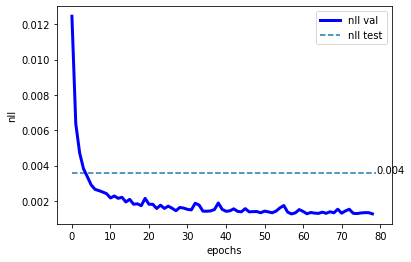

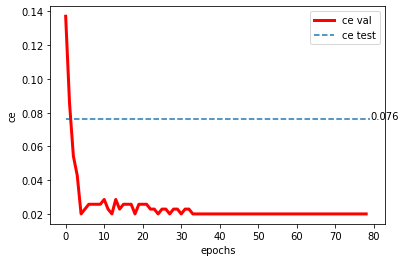

In [25]:
# print the final results of the model
print(f'-> FINAL PERFORMANCE: nll={ts_test_loss}, ce={ts_test_error}')
# write the results to a file
f = open("results_assignment5/" + 'best_model_test_loss.txt', "w")
f.write('NLL: ' + str(ts_test_loss) + '\nCE: ' + str(ts_test_error))
f.close()
# save the model
torch.save(best_model, "best_model" + '.model')
# create plots for the loss and the classification of the model for both testing and trainig sessions
plot_curve("results_assignment5/", tr_nll_value, file_name='best_model_nll_val_curve.pdf', ylabel='nll', test_eval=ts_test_loss)
plot_curve("results_assignment5/", tr_error_value, file_name='best_model_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=ts_test_error)

### 4.3 Convergence Plot

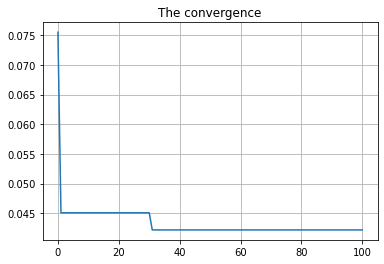

In [26]:
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title('The convergence')
plt.grid()

### 4.4 Confusion Matrix

In [48]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

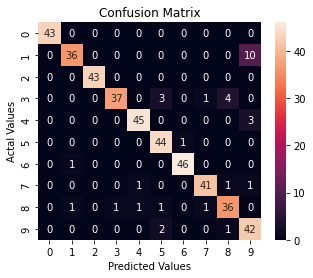

In [96]:
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import multilabel_confusion_matrix

# To create a confusion matrix, we run the model on the training set and reserve-
# the predictions and the real values seperately
batched_y_preds = []
batched_y_tests = []
for indx_batch, (batch, targets) in enumerate(test_loader):
    y_pred = best_model.classify(batch)
    y_test = targets.long()
    batched_y_preds.append(y_pred)
    batched_y_tests.append(y_test)

y_preds = np.asarray(torch.cat([x for x in batched_y_preds], dim=0))
y_tests = np.asarray(torch.cat([x for x in batched_y_tests], dim=0))
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cm = skm.confusion_matrix(y_tests, y_preds, sample_weight=None, labels=labels)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4','5','6','7','8','9'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()